In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

In [2]:
dfTrainData = pd.read_csv('C:/Users/weich/Google Drive/Rice University/3rd Semester/ELEC 578/HW7/train_data.csv')
dfTrainLabel = pd.read_csv('C:/Users/weich/Google Drive/Rice University/3rd Semester/ELEC 578/HW7/train_labels.csv')
dfTestData = pd.read_csv('C:/Users/weich/Google Drive/Rice University/3rd Semester/ELEC 578/HW7/test_data.csv')
dfTestLabel = pd.read_csv('C:/Users/weich/Google Drive/Rice University/3rd Semester/ELEC 578/HW7/test_labels.csv')

In [3]:
def GetData():
    TrainData_temp = dfTrainData.values[:,1:]
    TrainLabel_temp = dfTrainLabel.values[:,1:]
    shuffle_list = list(range(60000))
    np.random.shuffle(shuffle_list)
    
    TrainData = (TrainData_temp[shuffle_list[:50000],:]/255).astype('float64')
    TrainLabel = TrainLabel_temp[shuffle_list[:50000],:]
    ValidData = (TrainData_temp[shuffle_list[50000:],:]/255).astype('float64')
    ValidLabel = TrainLabel_temp[shuffle_list[50000:],:]
    TestData = (dfTestData.values[:,1:]/255).astype('float64')
    TestLabel = dfTestLabel.values[:,1:]
    return TrainData, TrainLabel, ValidData, ValidLabel, TestData, TestLabel

Loss/Accuracy of Training at epoch 1: 2.216976/0.749000
Loss/Accuracy of Validation at epoch 1: 1.384690/0.755800
Accuracy of Testing at epoch 1: 0.764100
Loss/Accuracy of Training at epoch 2: 0.965627/0.817000
Loss/Accuracy of Validation at epoch 2: 0.811742/0.823700
Accuracy of Testing at epoch 2: 0.837000
Loss/Accuracy of Training at epoch 3: 0.670556/0.860000
Loss/Accuracy of Validation at epoch 3: 0.600403/0.861900
Accuracy of Testing at epoch 3: 0.865100
Loss/Accuracy of Training at epoch 4: 0.545456/0.868000
Loss/Accuracy of Validation at epoch 4: 0.518921/0.869800
Accuracy of Testing at epoch 4: 0.877200
Loss/Accuracy of Training at epoch 5: 0.476991/0.880000
Loss/Accuracy of Validation at epoch 5: 0.463157/0.883000
Accuracy of Testing at epoch 5: 0.887000
Loss/Accuracy of Training at epoch 6: 0.436331/0.908000
Loss/Accuracy of Validation at epoch 6: 0.429574/0.885000
Accuracy of Testing at epoch 6: 0.892400
Loss/Accuracy of Training at epoch 7: 0.412683/0.899000
Loss/Accuracy 

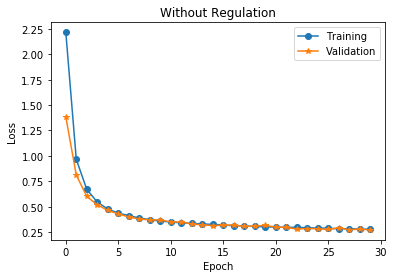

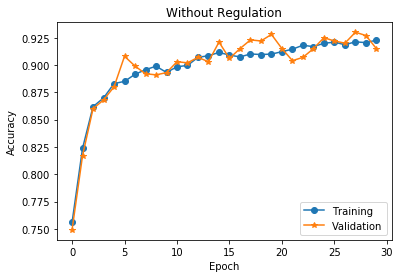

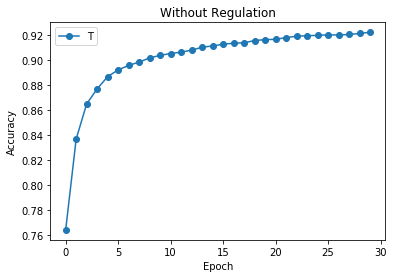

In [4]:
# Problem1.1
class NeuralNetwork(object):
  
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim):
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z):
        
        return 1.0 / (1+np.exp(-z))

    def diff_actFun(self, z):
      
        fz = 1.0 / (1+np.exp(-z))
        return fz * (1-fz)

    def feedforward(self, X):
      
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.actFun(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return self.probs

    def calculate_loss(self, X, y):
      
        num_examples = len(X)
        self.feedforward(X)
        
        y_onehot = OneHotEncoder(categories=[range(10)], sparse=False).fit_transform(y.reshape((-1, 1)))
        data_loss = - np.sum(np.log(self.probs) * y_onehot) / num_examples

        return data_loss

    def predict(self, X):
      
        self.feedforward(X)
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
      
        num_examples = len(X)
        
        # dL/da2
        dLda2 = - OneHotEncoder(categories=[range(10)], sparse=False).fit_transform(y.reshape((-1, 1))) / self.probs / num_examples
        # da2/dz2
        da2dz2 = np.zeros(self.probs.shape + (self.probs.shape[-1],))
        for i in range(num_examples):
            da2dz2[i, :, :] = np.diag(self.probs[i, :]) - np.outer(self.probs[i, :], self.probs[i, :])
        # dz2/da1
        dz2da1 = self.W2[None, :, :]
        # da1/dz1
        da1_dz1 = np.zeros(self.z1.shape + (self.z1.shape[-1],))
        for i in range(num_examples):
            da1_dz1[i, :, :] = np.diag(self.diff_actFun(self.z1[i, :]))
        # dL/dz2
        dLdz2 = np.einsum('ijk,ik->ij', da2dz2, dLda2)
        # dL/dz1
        dLdz1 = np.einsum('ijk,ik->ij', da1_dz1 @ dz2da1, dLdz2)
        
        # dW, db
        dW2 = dLdz2.T @ self.a1
        db2 = dLdz2.sum(0)[:, None]
        dW1 = dLdz1.T @ X
        db1 = dLdz1.sum(0)[:, None]

        return dW1.T, dW2.T, db1.T, db2.T

    def fit_model(self, X, y, epsilon, print_loss=True):
      
        # Forward propagation
        self.feedforward(X)
            
        # Backpropagation
        dW1, dW2, db1, db2 = self.backprop(X, y)

        # Gradient descent parameter update
        self.W1 += -epsilon * dW1
        self.b1 += -epsilon * db1
        self.W2 += -epsilon * dW2
        self.b2 += -epsilon * db2

def main():
    model = NeuralNetwork(nn_input_dim=784, nn_hidden_dim=300 , nn_output_dim=10)
    val_loss = np.zeros(30)
    train_loss = np.zeros(30)
    val_acc = np.zeros(30)
    train_acc = np.zeros(30)
    test_acc = np.zeros(30)
    for epoch in range(30):
        # shuffle
        [TrainData, TrainLabel, ValidData, ValidLabel, TestData, TestLabel] = GetData()

        batch_size = 1000
        
        # Training
        # Training loss
        loss = 0
        for i in range(50):
            
            X = TrainData[batch_size*i:batch_size*(i+1),:]
            y = TrainLabel[batch_size*i:batch_size*(i+1)]
            model.fit_model(X, y, (1/(i+1))**0.5)

            loss += model.calculate_loss(X, y)

        train_loss[epoch] = loss
        
        # Training accuracy
        prediction = model.predict(X)
        count = 0
        for j in range(len(prediction)):
            if(prediction[j] == y[j]):
                count += 1
        train_acc[epoch] = count/len(prediction)
        print("Loss/Accuracy of Training at epoch %i: %f/%f" % (epoch+1, train_loss[epoch]/50, train_acc[epoch]))
        
        # Validation
        # Validation loss
        loss = 0
        for i in range(10):
            
            X = ValidData[batch_size*i:batch_size*(i+1),:]
            y = ValidLabel[batch_size*i:batch_size*(i+1)]

            loss += model.calculate_loss(X, y)

        val_loss[epoch] = loss
        
        # Validation accuracy
        prediction = model.predict(ValidData)
        count = 0
        for j in range(len(prediction)):
            if(prediction[j] == ValidLabel[j]):
                count += 1
        val_acc[epoch] = count/len(prediction)
        print("Loss/Accuracy of Validation at epoch %i: %f/%f" % (epoch+1, val_loss[epoch]/10, val_acc[epoch]))
        
        # Testing accuracy
        prediction = model.predict(TestData)
        count = 0
        for j in range(len(prediction)):
            if(prediction[j] == TestLabel[j]):
                count += 1
        test_acc[epoch] = count/len(prediction)
        print("Accuracy of Testing at epoch %i: %f" % (epoch+1, test_acc[epoch]))

    # plot
    plt.figure(1)
    plt.plot(range(30), np.array(train_loss)/50, '-o')
    plt.plot(range(30), np.array(val_loss)/10, '-*')
    plt.legend(('Training', 'Validation'))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Without Regulation')
    plt.show()
               
    plt.figure(2)
    plt.plot(range(30), np.array(val_acc), '-o')
    plt.plot(range(30), np.array(train_acc), '-*')
    plt.legend(('Training', 'Validation'))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Without Regulation')
    plt.show()
    
    plt.figure(3)
    plt.plot(range(30), np.array(test_acc), '-o')
    plt.legend(('Testing'))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Without Regulation')
    plt.show()

if __name__ == "__main__":
    main()

Loss/Accuracy of Training at epoch 1: 2.173809/0.804000
Loss/Accuracy of Validation at epoch 1: 1.359370/0.771800
Accuracy of Testing at epoch 1: 0.780500
Loss/Accuracy of Training at epoch 2: 0.965206/0.826000
Loss/Accuracy of Validation at epoch 2: 0.816663/0.833200
Accuracy of Testing at epoch 2: 0.842100
Loss/Accuracy of Training at epoch 3: 0.695431/0.869000
Loss/Accuracy of Validation at epoch 3: 0.631913/0.860200
Accuracy of Testing at epoch 3: 0.863900
Loss/Accuracy of Training at epoch 4: 0.575395/0.852000
Loss/Accuracy of Validation at epoch 4: 0.550999/0.870900
Accuracy of Testing at epoch 4: 0.878600
Loss/Accuracy of Training at epoch 5: 0.511136/0.893000
Loss/Accuracy of Validation at epoch 5: 0.503792/0.880600
Accuracy of Testing at epoch 5: 0.887800
Loss/Accuracy of Training at epoch 6: 0.472606/0.872000
Loss/Accuracy of Validation at epoch 6: 0.475978/0.886000
Accuracy of Testing at epoch 6: 0.894200
Loss/Accuracy of Training at epoch 7: 0.454293/0.879000
Loss/Accuracy 

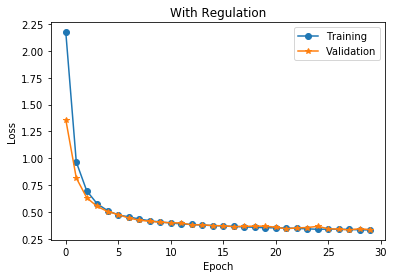

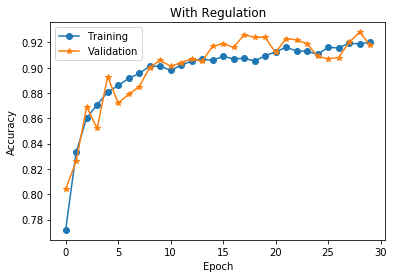

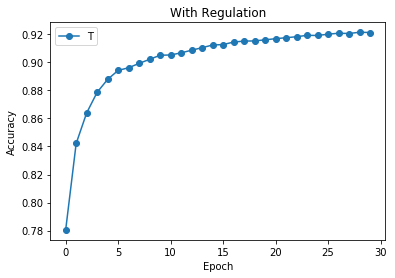

In [5]:
# Problem1.2
class NeuralNetwork(object):
  
    def __init__(self, nn_input_dim, nn_hidden_dim , nn_output_dim, reg_lambda=0.0001):
        self.nn_input_dim = nn_input_dim
        self.nn_hidden_dim = nn_hidden_dim
        self.nn_output_dim = nn_output_dim
        self.reg_lambda = reg_lambda
        
        self.W1 = np.random.randn(self.nn_input_dim, self.nn_hidden_dim) / np.sqrt(self.nn_input_dim)
        self.b1 = np.zeros((1, self.nn_hidden_dim))
        self.W2 = np.random.randn(self.nn_hidden_dim, self.nn_output_dim) / np.sqrt(self.nn_hidden_dim)
        self.b2 = np.zeros((1, self.nn_output_dim))

    def actFun(self, z):
        
        return 1.0 / (1+np.exp(-z))

    def diff_actFun(self, z):
      
        fz = 1.0 / (1+np.exp(-z))
        return fz * (1-fz)

    def feedforward(self, X):
      
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.actFun(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        exp_scores = np.exp(self.z2)
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        return self.probs

    def calculate_loss(self, X, y):
      
        num_examples = len(X)
        self.feedforward(X)
        
        y_onehot = OneHotEncoder(categories=[range(10)], sparse=False).fit_transform(y.reshape((-1, 1)))
        data_loss = - np.sum(np.log(self.probs) * y_onehot) / num_examples
        
        # Add regulatization term to loss (optional)
        data_loss += self.reg_lambda * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))

        return data_loss

    def predict(self, X):
      
        self.feedforward(X)
        return np.argmax(self.probs, axis=1)

    def backprop(self, X, y):
      
        num_examples = len(X)
        
        # dL/da2
        dLda2 = - OneHotEncoder(categories=[range(10)], sparse=False).fit_transform(y.reshape((-1, 1))) / self.probs / num_examples
        # da2/dz2
        da2dz2 = np.zeros(self.probs.shape + (self.probs.shape[-1],))
        for i in range(num_examples):
            da2dz2[i, :, :] = np.diag(self.probs[i, :]) - np.outer(self.probs[i, :], self.probs[i, :])
        # dz2/da1
        dz2da1 = self.W2[None, :, :]
        # da1/dz1
        da1_dz1 = np.zeros(self.z1.shape + (self.z1.shape[-1],))
        for i in range(num_examples):
            da1_dz1[i, :, :] = np.diag(self.diff_actFun(self.z1[i, :]))
        # dL/dz2
        dLdz2 = np.einsum('ijk,ik->ij', da2dz2, dLda2)
        # dL/dz1
        dLdz1 = np.einsum('ijk,ik->ij', da1_dz1 @ dz2da1, dLdz2)
        
        # dW, db
        dW2 = dLdz2.T @ self.a1
        db2 = dLdz2.sum(0)[:, None]
        dW1 = dLdz1.T @ X
        db1 = dLdz1.sum(0)[:, None]

        return dW1.T, dW2.T, db1.T, db2.T

    def fit_model(self, X, y, epsilon, print_loss=True):
      
        # Forward propagation
        self.feedforward(X)
            
        # Backpropagation
        dW1, dW2, db1, db2 = self.backprop(X, y)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += self.reg_lambda * self.W2
        dW1 += self.reg_lambda * self.W1

        # Gradient descent parameter update
        self.W1 += -epsilon * dW1
        self.b1 += -epsilon * db1
        self.W2 += -epsilon * dW2
        self.b2 += -epsilon * db2

def main():
    model = NeuralNetwork(nn_input_dim=784, nn_hidden_dim=300 , nn_output_dim=10)
    val_loss = np.zeros(30)
    train_loss = np.zeros(30)
    val_acc = np.zeros(30)
    train_acc = np.zeros(30)
    test_acc = np.zeros(30)
    for epoch in range(30):
        # shuffle
        [TrainData, TrainLabel, ValidData, ValidLabel, TestData, TestLabel] = GetData()

        batch_size = 1000
        
        # Training
        # Training loss
        loss = 0
        for i in range(50):
            
            X = TrainData[batch_size*i:batch_size*(i+1),:]
            y = TrainLabel[batch_size*i:batch_size*(i+1)]
            model.fit_model(X, y, (1/(i+1))**0.5)

            loss += model.calculate_loss(X, y)

        train_loss[epoch] = loss
        
        # Training accuracy
        prediction = model.predict(X)
        count = 0
        for j in range(len(prediction)):
            if(prediction[j] == y[j]):
                count += 1
        train_acc[epoch] = count/len(prediction)
        print("Loss/Accuracy of Training at epoch %i: %f/%f" % (epoch+1, train_loss[epoch]/50, train_acc[epoch]))

        # Validation
        # Validation loss
        loss = 0
        for i in range(10):
            
            X = ValidData[batch_size*i:batch_size*(i+1),:]
            y = ValidLabel[batch_size*i:batch_size*(i+1)]

            loss += model.calculate_loss(X, y)

        val_loss[epoch] = loss
        
        # Validation accuracy
        prediction = model.predict(ValidData)
        count = 0
        for j in range(len(prediction)):
            if(prediction[j] == ValidLabel[j]):
                count += 1
        val_acc[epoch] = count/len(prediction)
        print("Loss/Accuracy of Validation at epoch %i: %f/%f" % (epoch+1, val_loss[epoch]/10, val_acc[epoch]))
        
        
        # Testing accuracy
        prediction = model.predict(TestData)
        count = 0
        for j in range(len(prediction)):
            if(prediction[j] == TestLabel[j]):
                count += 1
        test_acc[epoch] = count/len(prediction)
        print("Accuracy of Testing at epoch %i: %f" % (epoch+1, test_acc[epoch]))
    
    # plot
    plt.figure(1)
    plt.plot(range(30), np.array(train_loss)/50, '-o')
    plt.plot(range(30), np.array(val_loss)/10, '-*')
    plt.legend(('Training', 'Validation'))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('With Regulation')
    plt.show()
               
    plt.figure(2)
    plt.plot(range(30), np.array(val_acc), '-o')
    plt.plot(range(30), np.array(train_acc), '-*')
    plt.legend(('Training', 'Validation'))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('With Regulation')
    plt.show()
    
    plt.figure(3)
    plt.plot(range(30), np.array(test_acc), '-o')
    plt.legend(('Testing'))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('With Regulation')
    plt.show()

if __name__ == "__main__":
    main()